# Index <a class="anchor" id="MuonSource.i"></a>

* [Monte Carlo with non-monochromatic beam](#MuonSource.4.)
    * [Functions](#MuonSource.4.1.)
        * [Functions for $\beta^*_\mu$, $\beta_e$ and $||\vec{p}^*_{\mu}||$](#MuonSource.4.1.1.)
        * [Functions for differential cross section, cross section and distribution $g(\theta^*)$](#MuonSource.4.1.2.)
        * [Functions for CDF of $g(\theta^*)$](#MuonSource.4.1.3.)
        * [Functions for boost (from CM to Lab frame)](#MuonSource.4.1.4.)
    * [Data generation](#MuonSource.4.2.)
    * [Distribution $g(\theta^*,s)$](#MuonSource.4.3.)
    * [Monte Carlo simulation through rejection sampling method](#MuonSource.4.4.)
    * [Boost from CM to Lab frame](#MuonSource.4.5.)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import scipy.optimize as optimize

In [2]:
#Constants
alpha = 0.00729735257
mmu = 105.66 #MeV
me = 0.511 #MeV

# 4. Monte Carlo with non-monochromatic beam <a class="anchor" id="MuonSource.4."></a>
* [Index](#MuonSource.i)

In [3]:
# CONSTANTS
alpha = 0.00729735257
mmu = 105.66 #MeV
me = 0.511 #MeV

## 4.1. Functions <a class="anchor" id="MuonSource.4.1."></a>
* [Index](#MuonSource.i)

### 4.1.1. Functions for $\beta^*_\mu$, $\beta_e$ and $||\vec{p}^*_{\mu}||$ <a class="anchor" id="MuonSource.4.1.1."></a>
* [Index](#MuonSource.i)

$$
\begin{align}
\beta_\mu^* &= \sqrt{1-\frac{4 m_\mu^2}{s}}\\
&\\
\beta^*_e &= \beta = \frac{||\vec{p}_e^*||^2}{\mathcal{E}_e^*} = \frac{\sqrt{(\mathcal{E}_e^*)^2 - m_e^2}}{\mathcal{E}_e^*} = \sqrt{1- \frac{m^2_e}{(\mathcal{E}_e^*)^2}} = \sqrt{1-\frac{4 m_e^2}{s}}\\
&\\
\vec{p}_\mu^* &= ||\vec{p}_\mu^*|| (\cos \theta^*, \sin\theta^* \cos\varphi^*, \sin\theta^*\sin\varphi^*) = \sqrt{\frac{s}{4} - m_\mu^2} \ (\cos \theta^*, \sin\theta^* \cos\varphi^*, \sin\theta^*\sin\varphi^*)
\end{align}
$$

In [4]:
def beta_mu(s):
    return np.sqrt(1 - 4*(mmu**2)/s)

def beta_e(s):
    return np.sqrt(1 - 4*(me**2)/s)

def gamma_e(s):
    return 1 / np.sqrt(1 - beta_e(s)**2)

def p_mu_cm(s):
    return np.sqrt(s/4 - mmu**2)

### 4.1.2. Functions for differential cross section, cross section and distribution $g(\theta^*)$ <a class="anchor" id="MuonSource.4.1.2."></a>
* [Index](#MuonSource.i)

$$
\begin{align}
g(\theta^*) &= \frac{\mathrm{d}\sigma}{\mathrm{d}\theta^*} = \int_0^{2\pi} \mathrm{d}\varphi^* \frac{1}{\sigma} \frac{\mathrm{d}\sigma}{\mathrm{d}\Omega} \sin\theta^* = \frac{2\pi \sin\theta^*}{\sigma} \frac{\mathrm{d}\sigma}{\mathrm{d}\Omega} \\
&\\
&= \frac{2\pi \sin\theta^*}{\sigma} \frac{\alpha^2}{4s} \left(1- \frac{4 m_\mu^2}{s}\right)^{1/2} \left(1- \frac{4 m_e^2}{s}\right)^{-1/2}\left( 1+ \frac{4}{s} (m_e^2 + m_\mu^2) + \left(1-\frac{4 m_e^2}{s}\right)\left(1-\frac{4 m_\mu^2}{s}\right)\cos^2\theta^*\right) \\
&\\
\sigma &= \int_0^\pi \frac{\mathrm{d}\sigma}{\mathrm{d}\cos\theta^*}(\theta^*)\sin\theta^* \mathrm{d}\theta^* = \frac{4\pi \alpha^2}{3 s^3} \frac{\sqrt{1-\frac{4 m_\mu^2}{s}}}{\sqrt{1-\frac{4 m_e^2}{s}}} (2 m_e^2 + s)(2m_\mu^2 + s)
\end{align}
$$

In [5]:
def dsigma(s, theta):
    return (2 * np.pi) * (alpha**2 / (4*s)) * (beta_mu(s) / beta_e(s)) * (1. + 4. * (me**2 + mmu**2) / s + beta_mu(s)**2 * beta_e(s)**2 * np.cos(theta)**2)

def sigma(s):
    return (4 * np.pi * alpha**2) / (3 * s**3) * (beta_mu(s) / beta_e(s)) * (2 * me**2 + s) * (2 * mmu**2 + s)

def dsigma_norm(s, theta):
    return (2 * np.pi) * (3 * s * (4 * (me**2 + mmu**2) + s) + 3 * (-4 * me**2 + s) * (-4*mmu**2 + s) * np.cos(theta)**2) / \
           (16 * np.pi * (2 * me**2 + s) * (2 * mmu**2 + s))

def dsigma_norm_dist(s, theta):
    return np.sin(theta) * (2 * np.pi) * (3 * s * (4 * (me**2 + mmu**2) + s) + 3 * (-4 * me**2 + s) * (-4*mmu**2 + s) * np.cos(theta)**2) / \
           (16 * np.pi * (2 * me**2 + s) * (2 * mmu**2 + s))

### 4.1.3. Functions for CDF of $g(\theta^*)$ <a class="anchor" id="MuonSource.4.1.3."></a>
* [Index](#MuonSource.i)

$$
\begin{align}
\text{CDF}[g(\theta^*)] &= \int_{0}^{\pi} \mathrm{d}\theta^* \frac{\mathrm{d}\sigma}{\mathrm{d}\theta^*} \\
&\\
&= \frac{2\pi \sin\theta^*}{\sigma} \frac{\alpha^2}{4s} \left(1- \frac{4 m_\mu^2}{s}\right)^{1/2} \left(1- \frac{4 m_e^2}{s}\right)^{-1/2}\left( 1+ \frac{4}{s} (m_e^2 + m_\mu^2) + \left(1-\frac{4 m_e^2}{s}\right)\left(1-\frac{4 m_\mu^2}{s}\right)\cos^2\theta^*\right)
\end{align}
$$

In [6]:
def cdf_dsigma_norm_dist(s,theta):
    return (2 * np.pi) * (3 * s * (4 * (me**2 + mmu**2) + s) * (- np.cos(theta) + 1) + (-4 * me**2 + s) * (-4*mmu**2 + s) * (- np.cos(theta)**3 + 1)) / \
           (16 * np.pi * (2 * me**2 + s) * (2 * mmu**2 + s))

### 4.1.4. Functions for boost (from CM to Lab frame) <a class="anchor" id="MuonSource.4.1.4."></a>
* [Index](#MuonSource.i)

$$\tan\theta_\mu = \frac{\sin\theta^*_\mu}{\gamma \left( \cos\theta^*_\mu + \frac{\beta}{\beta^*_\mu} \right)}$$

In [7]:
def theta_boost(s, theta_cm):
    return np.sin(theta_cm) / \
           (gamma_e(s) * (np.cos(theta_cm) + beta_e(s)/beta_mu(s)))

## 4.2. Data generation <a class="anchor" id="MuonSource.4.2."></a>
* [Index](#MuonSource.i)

The distributions used to generate data read:

$$
g(x,y; r) =
\begin{cases}
    \frac{1}{\pi r^2} & (y,z) \ \text{s.t.} \ y^2 + z^2 \le r^2 \\
    0 & \text{otherwise}
\end{cases}
\qquad
h(E; \mu,\sigma) =
\begin{cases}
    \frac{1}{\sqrt{2\pi}\sigma} e^{ - \frac{(E-\mu)^2}{2\sigma^2} } & \text{for} \ (y,z) \ \text{s.t.} \ y^2 + z^2 \le r^2 \\
    0 & \text{otherwise}
\end{cases}
$$

In [8]:
def generate(N,r,mu,sigma):
    ys = []
    zs = []
    Es = []
    while len(ys) < N:
        y,z = np.random.uniform(-r,r, size=2)
        if y*y+z*z <= r*r:
            E = np.random.normal(mu,sigma)
            ys.append(y)
            zs.append(z)
            Es.append(E)
        else:
            continue
    
    ys = np.array(ys)
    zs = np.array(zs)
    Es = np.array(Es)
    
    return ys, zs, Es

In [9]:
N = 10**6
r = 1 #cm
E = 52.9 #GeV
sigma = 0.5 #GeV

In [ ]:
%timeit ys,zs,Es = generate(N,r,E,sigma)

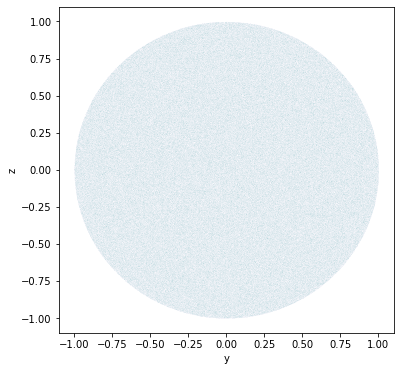

In [11]:
plt.figure(figsize=(6,6))
plt.scatter(ys,zs,s=0.00001)
plt.xlabel('y')
plt.ylabel('z')
plt.show()

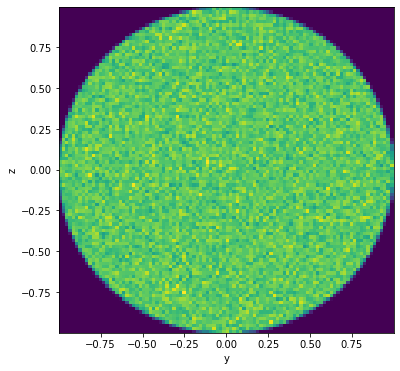

In [12]:
plt.figure(figsize=(6,6))
plt.hist2d(ys,zs,bins=100,weights=Es)
plt.xlabel('y')
plt.ylabel('z')
plt.show()

In [14]:
print(sqrt_s)

[233.8047174  231.32504504 231.54944621 ... 232.19312083 233.61614709
 233.30488497]


$$\tan\theta_\mu = \frac{\sin\theta^*_\mu}{\gamma \left( \cos\theta^*_\mu + \frac{\beta}{\beta^*_\mu} \right)}$$

$$\beta_\mu^* = \sqrt{1-\frac{4 m_\mu^2}{s}}$$

$$\beta^*_e = \beta = \frac{||\vec{p}_e^*||^2}{\mathcal{E}_e^*} = \frac{\sqrt{(\mathcal{E}_e^*)^2 - m_e^2}}{\mathcal{E}_e^*} = \sqrt{1- \frac{m^2_e}{(\mathcal{E}_e^*)^2}} = \sqrt{1-\frac{4 m_e^2}{s}}$$

## 4.3. Distribution $g(\theta^*,s)$ <a class="anchor" id="MuonSource.4.3."></a>
* [Index](#MuonSource.i)

In [15]:
ths = np.linspace(0,np.pi,1000)
sqs = np.linspace(np.min(sqrt_s),np.max(sqrt_s),1000)
thsv, sqsv = np.meshgrid(ths,sqs)
thsv = thsv.reshape(-1,)
sqsv = sqsv.reshape(-1,)
gs  = dsigma_norm(sqsv**2,thsv) * np.sin(thsv)

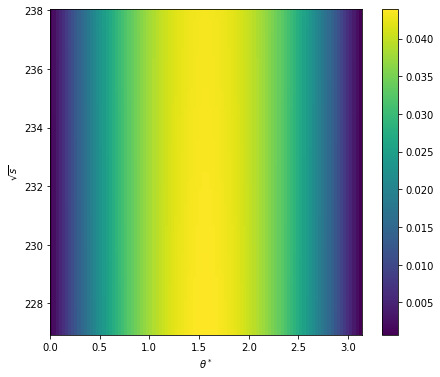

In [16]:
plt.figure(figsize=(7,6))
plt.hist2d(thsv,sqsv,weights=gs, bins=100, density=True)
plt.xlabel("$\\theta^*$")
plt.ylabel("$\\sqrt{s}$")
plt.colorbar()
plt.show()

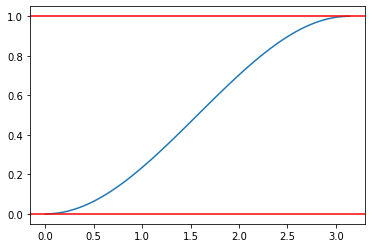

In [17]:
thetas = np.linspace(0,np.pi,100)
plt.plot(thetas,cdf_dsigma_norm_dist(230**2,thetas))
plt.axhline(0, color='red')
plt.axhline(1, color='red')
plt.show()

## 4.4. Monte Carlo simulation through rejection sampling method <a class="anchor" id="MuonSource.4.4."></a>
* [Index](#MuonSource.i)

It returns $N$ events with the following variables:
* $y$: coordinate from which the particle comes out from the target.
* $z$: coordinate from which the particle comes out from the target.
* $E$: energy of the positron in the Lab frame (energy of the beam).
* $\sqrt{s}$: energy in the CM frame.
* $\theta$: azimuthal angle in the CM fram.
* $\phi$: polar angle in the CM frame.

In [18]:
k = 1.0
def event_generator(N, r=1, E=52.9, sigma=0.5):
    ys, zs, Es = generate(N,r,E,sigma)
    ths = np.zeros(N)
    sqs = np.sqrt(Es/(2*me*1e-3))
    phs = np.random.uniform(0,2*np.pi, size=N)
    
    i = 0
    while i<N:
        u = np.random.uniform(0, np.pi)
        v = np.random.uniform(0, k)
        if v <= dsigma_norm(sqs[i]**2,u)*np.sin(u):
            ths[i] = u
            i += 1
            continue
    
    return ys, zs, Es, sqs, ths, phs

In [19]:
ys_cm, zs_cm, Es_cm, sqs_cm, ths_cm, phs_cm = event_generator(1000000, E=52.9, sigma=0.5)

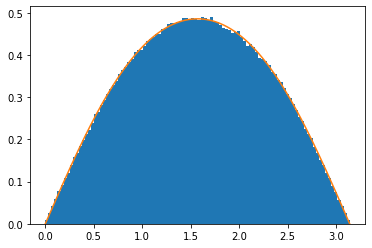

In [20]:
x = np.arange(0,np.pi,0.001)
plt.hist(ths_cm, bins=100, density=True)
plt.plot(x, dsigma_norm_dist(230**2,x))
plt.show()

## 4.5. Boost from CM to Lab frame <a class="anchor" id="MuonSource.4.5."></a>
* [Index](#MuonSource.i)

In [21]:
E_cm  = sqs_cm / 2
px_cm = p_mu_cm(sqs_cm**2) * np.cos(ths_cm)
py_cm = p_mu_cm(sqs_cm**2) * np.sin(ths_cm) * np.cos(phs_cm)
pz_cm = p_mu_cm(sqs_cm**2) * np.sin(ths_cm) * np.sin(phs_cm)

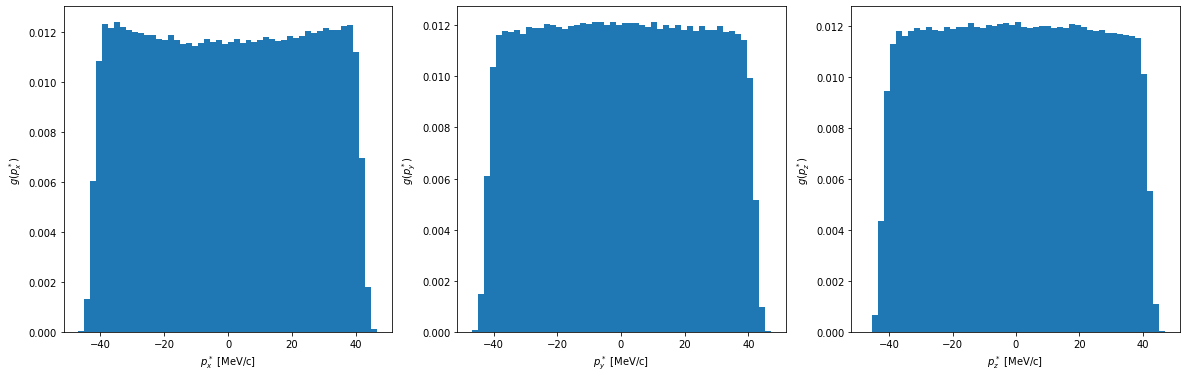

In [22]:
plt.figure(figsize=(20,6))

plt.subplot(1,3,1)
plt.hist(px_cm, bins=50, density=True)
plt.xlabel('$p^*_x$ [MeV/c]')
plt.ylabel('$g(p^*_x)$')

plt.subplot(1,3,2)
plt.hist(py_cm, bins=50, density=True)
plt.xlabel('$p^*_y$ [MeV/c]')
plt.ylabel('$g(p^*_y)$')

plt.subplot(1,3,3)
plt.hist(pz_cm, bins=50, density=True)
plt.xlabel('$p^*_z$ [MeV/c]')
plt.ylabel('$g(p^*_z)$')

plt.show()

In [23]:
ths_cm_boosted = theta_boost(sqs_cm**2,ths_cm)

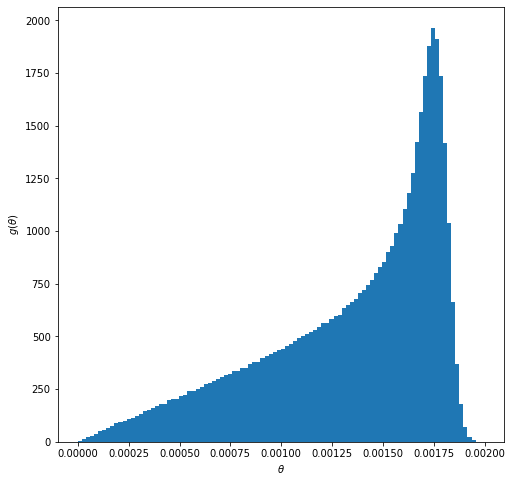

In [24]:
plt.figure(figsize=(8,8))
plt.hist(ths_cm_boosted, bins=100, density=True)
plt.xlabel('$\\theta$')
plt.ylabel('$g(\\theta)$')
plt.show()

In [ ]:
E_mu_2_lab  = gamma_e(sqs_cm**2) * ( E_cm  - px_cm*beta_e(sqs_cm**2))
px_mu_2_lab = gamma_e(sqs_cm**2) * (-px_cm + E_cm *beta_e(sqs_cm**2))
py_mu_2_lab = -py_cm
pz_mu_2_lab = -pz_cm

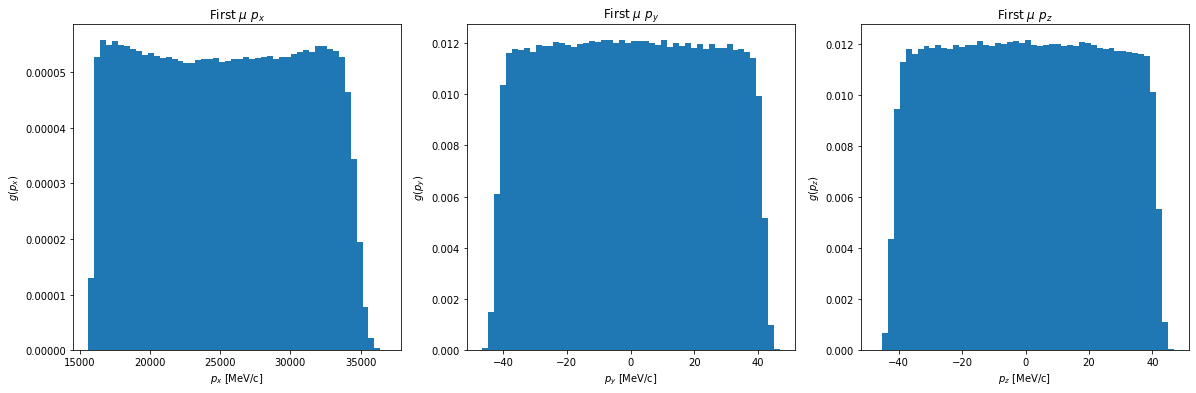

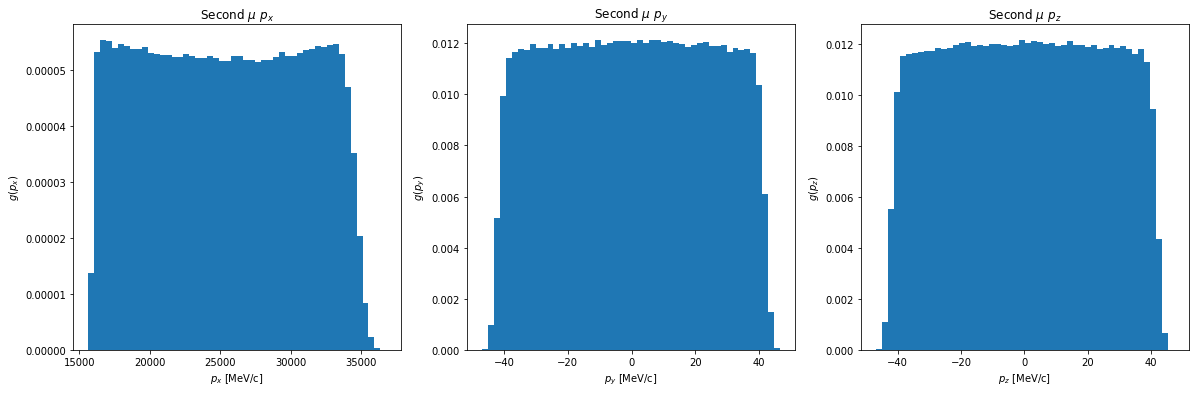

In [26]:
plt.figure(figsize=(20,6))

plt.subplot(1,3,1)
plt.hist(px_mu_1_lab, bins=50, density=True)
plt.title('First $\\mu$ $p_x$')
plt.xlabel('$p_x$ [MeV/c]')
plt.ylabel('$g(p_x)$')

plt.subplot(1,3,2)
plt.hist(py_mu_1_lab, bins=50, density=True)
plt.title('First $\\mu$ $p_y$')
plt.xlabel('$p_y$ [MeV/c]')
plt.ylabel('$g(p_y)$')

plt.subplot(1,3,3)
plt.hist(pz_mu_1_lab, bins=50, density=True)
plt.title('First $\\mu$ $p_z$')
plt.xlabel('$p_z$ [MeV/c]')
plt.ylabel('$g(p_z)$')

plt.show()


plt.figure(figsize=(20,6))
plt.title('Second $\\mu$')

plt.subplot(1,3,1)
plt.hist(px_mu_2_lab, bins=50, density=True)
plt.title('Second $\\mu$ $p_x$')
plt.xlabel('$p_x$ [MeV/c]')
plt.ylabel('$g(p_x)$')

plt.subplot(1,3,2)
plt.hist(py_mu_2_lab, bins=50, density=True)
plt.title('Second $\\mu$ $p_y$')
plt.xlabel('$p_y$ [MeV/c]')
plt.ylabel('$g(p_y)$')

plt.subplot(1,3,3)
plt.hist(pz_mu_2_lab, bins=50, density=True)
plt.title('Second $\\mu$ $p_z$')
plt.xlabel('$p_z$ [MeV/c]')
plt.ylabel('$g(p_z)$')

plt.show()